In [1]:
import numpy as np
import sys
sys.path.append('/home3/ebrahim2/beyond-brainscore/run_reg_scripts/')
from helper_funcs import combine_MSE_across_folds

In [2]:
rand_str = 'hi-1hi'
rand_str.replace('-1', '5')

'hi5hi'

In [66]:
def compare_perf_when_using_val(dataset, y_true, test_fold_idx, layer_range, mse_intercept, model_name, model_name_y_hat, shuffled=False):
    
    val_scores_across_layers = []
    test_score = []
    
    if shuffled:
        base_path = f'/data/LLMs/brainscore/results_{dataset}/shuffled/'
    else:
        base_path = f'/data/LLMs/brainscore/results_{dataset}/'
    
    for ln in layer_range:
        
        model_name_ln = model_name.replace('-1', f'{ln}')
        
        # val_scores is of shape number of outer folds x number of lang voxels/electrodes/fROIs
        val_scores = np.mean(np.load(f'{base_path}{dataset}_{model_name_ln}.npz')['val_scores'],axis=-1)
        val_scores_across_layers.append(val_scores)
        
        # out_of_sample_r2 is of shape number of lang voxels/electrodes/fROIs
        # each R2 value is computed by pooling MSE values across  
        test_score.append(np.nanmean(np.load(f'{base_path}{dataset}_{model_name_ln}.npz')['out_of_sample_r2']))

        
    val_scores_across_layers_stacked = np.vstack(val_scores_across_layers)
    best_val_layers = np.argmax(val_scores_across_layers_stacked,axis=0)
    stacked_mse = []    
    best_val_layers = np.repeat(10,8)
    for idx, bvl_idx in enumerate(best_val_layers): 
        
        bvl = layer_range[bvl_idx]
        
        model_name_bvl = model_name_y_hat.replace('-1', f'{bvl}')
        y_hat = np.load(f'{base_path}{dataset}_{model_name_bvl}.npz')['y_hat']
        mse = (y_true-y_hat)**2
        start_idx = test_fold_idx[idx]
        end_idx = test_fold_idx[idx+1]
        stacked_mse.append(mse[start_idx:end_idx])
        
    stacked_mse_np = np.mean(np.vstack(stacked_mse), axis=0)
    out_of_sample_r2_by_val = 1 - stacked_mse_np/mse_intercept
    out_of_sample_r2_by_val[mse_intercept==0] = 0

    print("Performance when using val to select best layer/hparam: ", np.nanmean(out_of_sample_r2_by_val))
    print("Performance when using test set: ", np.max(test_score))       
    
    
def check_if_y_hat_saved(model_name, dataset):
    model = np.load(f'/data/LLMs/brainscore/results_{dataset}/shuffled/{dataset}_{model_name}.npz')
    
    try:
        y_hat = model['y_hat']
        print('y_hat was saved')
        
    except:
        print("y hat was not saved")

GPT2-XL, SHUFFLED, PEREIRA 384
OASM, SHUFFLED, PEREIRA 384
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)
(12155,)


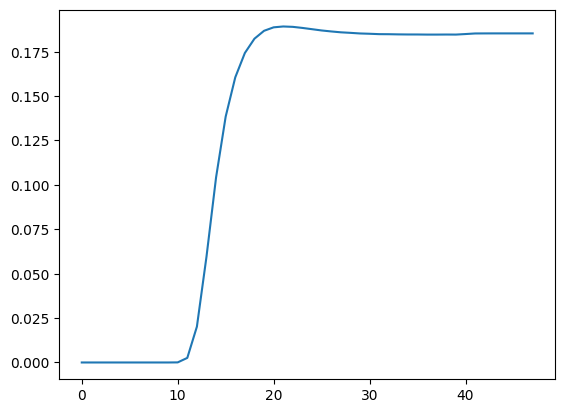

In [67]:
y_true_shuffled = np.load('/data/LLMs/brainscore/results_pereira/shuffled/y_test_ordered_384_lang.npy')
test_fold_size_shuffled = np.load('/data/LLMs/brainscore/results_pereira/shuffled/test_fold_size_384.npy')
test_fold_idx_shuffled = np.hstack(([0], np.cumsum(test_fold_size_shuffled)))
mse_intercept_shuffled = np.mean(np.load('/data/LLMs/brainscore/results_pereira/shuffled/mse_intercept_384_lang.npy'),axis=0)

print("GPT2-XL, SHUFFLED, PEREIRA 384")
#compare_perf_when_using_val('pereira', y_true_shuffled, 
#                            test_fold_idx_shuffled, 
#                            np.arange(48), 
#                            mse_intercept_shuffled,
#                            'gpt2-xl_layer_-1_1_384_m0', 'gpt2-xl_layer_-1_1_384_m0', shuffled=True)

print("OASM, SHUFFLED, PEREIRA 384")
ts = compare_perf_when_using_val('pereira', y_true_shuffled, 
                            test_fold_idx_shuffled, 
                            np.round(np.arange(0.1,4.81,0.1),3), 
                            mse_intercept_shuffled,
                            'OASM-all-sigma_-1_1_384_m0', 'OASM-all-sigma_-1_1_384_m0', shuffled=True)

plt.plot(ts)

In [6]:
y_true = np.load('/data/LLMs/brainscore/results_pereira/y_test_ordered_384_lang.npy')
test_fold_size = np.load('/data/LLMs/brainscore/results_pereira/test_fold_size_384.npy')
test_fold_idx = np.hstack(([0], np.cumsum(test_fold_size)))
mse_intercept = np.mean(np.load('/data/LLMs/brainscore/results_pereira/mse_intercept_384_lang.npy'),axis=0)

print("GPT2XL, CONTIG, PEREIRA 384")
compare_perf_when_using_val('pereira', y_true, test_fold_idx, np.arange(48), mse_intercept, 'gpt2-xl_layer_-1_1_384_m0', 'gpt2-xl_layer_-1_1_384')

print("POSITION, CONTIG, PEREIRA 384")
compare_perf_when_using_val('pereira', y_true, test_fold_idx, np.round(np.arange(0,4.8,0.1),3), mse_intercept, 'position_layer_-1_1_384_m0', 'position_layer_-1_1_384_m0')

GPT2XL, CONTIG, PEREIRA 384
Performance when using val to select best layer/hparam:  0.027341884
Performance when using test set:  0.029145310227305973
POSITION, CONTIG, PEREIRA 384
Performance when using val to select best layer/hparam:  0.01079761
Performance when using test set:  0.011573695663757759


/tmp/ipykernel_777822/3466418323.py:39: RuntimeWarning: invalid value encountered in divide
  out_of_sample_r2_by_val = 1 - stacked_mse_np/mse_intercept
